# Sheet 1: Error Propagation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from resample.bootstrap import variance

# create instance of pseudo-random number generator with fixed seed = 1
rng = np.random.default_rng(seed=1)

---

## Task 2: Error Propagation with Transformation
Now consider the following reparametrisation of $y = f(x)$:
    
$$y = 1 + \frac{x(1+x)}{b_1} + \frac{x(1-x)}{b_2}$$

### 2.1
Determine analytically the transformed parameters $b_1$ and $b_2$ and their covariance matrices.

---

The transformed covariance matrix is $\mathrm{Cov}(b) = J \,\mathrm{Cov}(a) \, J^T$, where $J$ is the Jacobi matrix containing the derivatives of the new parameters as a function of the old parameters.

We first express the $b_i$ as function of the $a_i$. Here we can neglect the term $+1$ because it occurs equally in both definitions.

\begin{align}
 a_1 x + a_2 x^2 &= \frac{x(1 + x)}{b_1} + \frac{x(1 - x)}{b_2} \\
                 &= \frac{x}{b_1} + \frac{x^2}{b_1} + \frac{x}{b_2} - \frac{x^2}{b_2} \\
                 &= x\left(\frac{1}{b_1} + \frac{1}{b_2}\right) + x^2\left(\frac{1}{b_1} - \frac{1}{b_2}\right) \,.
\end{align}

Thus

$$a_1 = \left(\frac{1}{b_1} + \frac{1}{b_2}\right) \quad\text{and}\quad a_2 = \left(\frac{1}{b_1} - \frac{1}{b_2}\right)$$

and

$$b_1 = \frac{2}{a_1 + a_2} \quad \text{and} \quad b_2 = \frac{2}{a_1 - a_2} \,.$$

For the Jacobian matrix of the transformation we get

\begin{equation}
    J = \begin{pmatrix}
        \frac{-2}{(a_1 + a_2)^2} & \frac{-2}{(a_1 + a_2)^2} \\
        \frac{-2}{(a_1 - a_2)^2} & \frac{+2}{(a_1 - a_2)^2}      
    \end{pmatrix} \quad \text{where} \quad J_{ij} = \frac{\partial b_i}{\partial a_j} \, .
\end{equation}

In [8]:
def trafo(a):
    a1, a2 = a
    b1 = 2 / (a1 + a2)
    b2 = 2 / (a1 - a2)
    return np.array([b1, b2])


denom1 = (a1 + a2) ** 2
denom2 = (a1 - a2) ** 2

J = np.array([[-2 / denom1, -2 / denom1], [-2 / denom2, 2 / denom2]])
cov_b = J @ cov_a @ J.T

trafo((a1, a2)), cov_b

(array([0.66666667, 2.        ]),
 array([[0.00088889, 0.01333333],
        [0.01333333, 0.328     ]]))

---

### 2.2
Determine the covariance matrix of the transformed parameters by Monte-Carlo simulation and compare with the analytical calculation.

_Hint_: If the covariance matrix is not what you expect, plot histograms of the transformed parameters and look for suspicious properties.

---

In [9]:
# generate b-distributions from previously generated a-distributions
b1s, b2s = trafo((a1s, a2s))

ncov_b = np.cov(b1s, b2s)
print(ncov_b)
print(ncov_b / cov_b)

[[9.02069227e-04 1.57500830e-02]
 [1.57500830e-02 3.47068952e+02]]
[[1.01482788e+00 1.18125622e+00]
 [1.18125622e+00 1.05813705e+03]]


We observe large deviations of the simulation from the analytical solution, which seem to originate from the parameter $b_2$. Further investigation of the distribution reveals outliers in the $b_2$ sample.

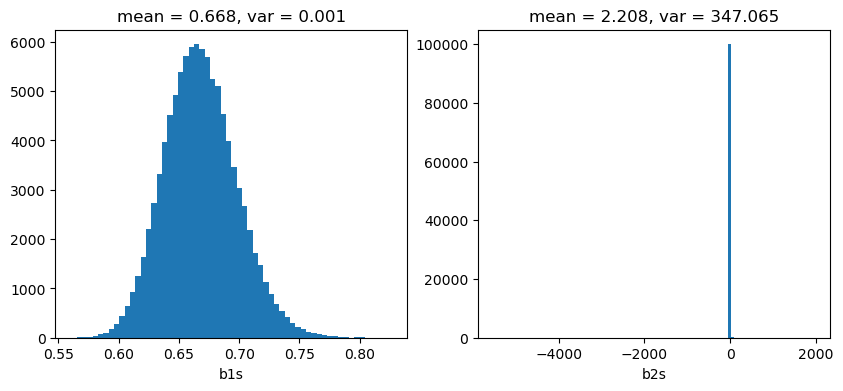

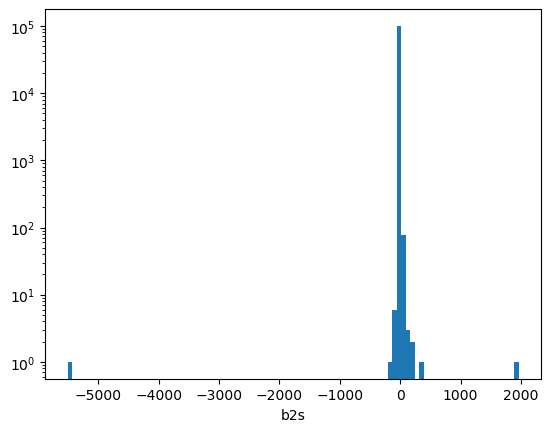

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(b1s, bins=60)
ax[0].set(title=f"mean = {np.mean(b1s):.3f}, var = {np.var(b1s):.3f}", xlabel="b1s")
ax[1].hist(b2s, bins=100)
ax[1].set(title=f"mean = {np.mean(b2s):.3f}, var = {np.var(b2s):.3f}", xlabel="b2s")

# plot y-axis logarithmically to reveal outliers
plt.figure()
plt.hist(b2s, bins=100)
plt.xlabel("b2s")
plt.semilogy();

Note: We don't expect the students to figure the following out by themselves, so it should be discussed in the exercise by the tutor.

The problem arises that for some combinations of values for $a_1$ and $a_2$ the denominator comes very close to `0`. This results in very large (unrealistic) values for $b_2$. We can counteract this by removing the smallest and largest 1% of the distribution.

b2_low: 1.195, b2_high: 5.953
Cut efficiency: 0.98


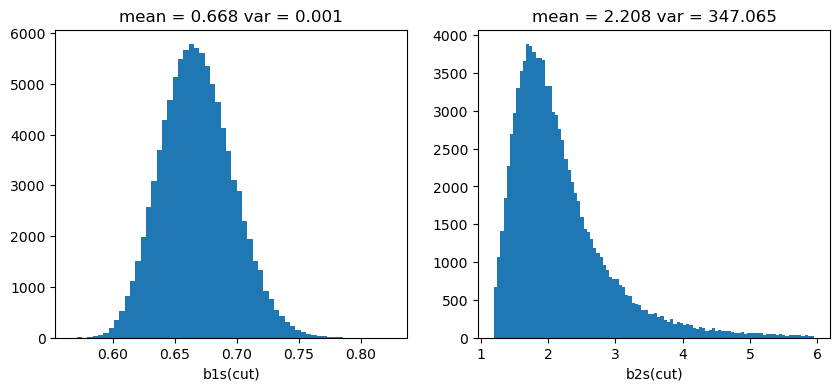

In [11]:
b2_low, b2_high = np.percentile(b2s, (1, 99))
print(f"b2_low: {b2_low:.3f},", f"b2_high: {b2_high:.3f}")
mask = np.logical_and(b2_low < b2s, b2s < b2_high)

# all values that meet this cut are written into a new array
b1s_cut = b1s[mask]
b2s_cut = b2s[mask]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(b1s_cut, bins=60)
ax[0].set(title=f"mean = {np.mean(b1s):.3f} var = {np.var(b1s):.3f}", xlabel="b1s(cut)")
ax[1].hist(b2s_cut, bins=100)
ax[1].set(title=f"mean = {np.mean(b2s):.3f} var = {np.var(b2s):.3f}", xlabel="b2s(cut)")
print(f"Cut efficiency: {len(b1s_cut)/len(b1s)}")

The covariance matrix of the cutted distribution is closer to the analytical result. They are not expected to be equal because the transformation is non-linear.

In [12]:
ncov_b = np.cov(b1s_cut, b2s_cut)
ncov_b, ncov_b / cov_b

(array([[0.00083038, 0.01479736],
        [0.01479736, 0.52207246]]),
 array([[0.93417458, 1.10980225],
        [1.10980225, 1.59168433]]))

---

## Task 3: Bias

Consider the transformation $y = f(x) = \sin(x)$ for a normally distributed $x$ with $\bar x = 0.8 \pm 0.3$.

In this case, $f(\bar x)$ is not equal to $\bar y$, the mean of the $y$-distribution, since $f(x)$ is not linear.

### 3.1
Calculate the bias $f(\bar x) - \bar y$ using the approximate formula from the lecture and subtract the bias from the naive result $f(\bar x)$.


---

The general formula to compute the bias for a function $y = f(x)$ to using a second order Taylor expansion is:

$$f(\bar x) - \bar y \approx -\frac{1}{2}\frac{\partial^2\!f}{\partial x^2}\, \sigma^2_{x}$$

In [13]:
x = 0.8
err_x = 0.3
var_x = err_x**2

y = np.sin(x)

d2f_dx2 = -np.sin(x)
bias = -0.5 * d2f_dx2 * var_x

print(f"Naive function result: {y:.3f}")
print(f"Bias: {bias:.3f}")
print(f"corrected function result: {(y-bias):.3f}")

Naive function result: 0.717
Bias: 0.032
corrected function result: 0.685


---
## 3.2
Check your calculation by Monte-Carlo simulation, by comparing the corrected function result with the mean of the transformed sample.

---

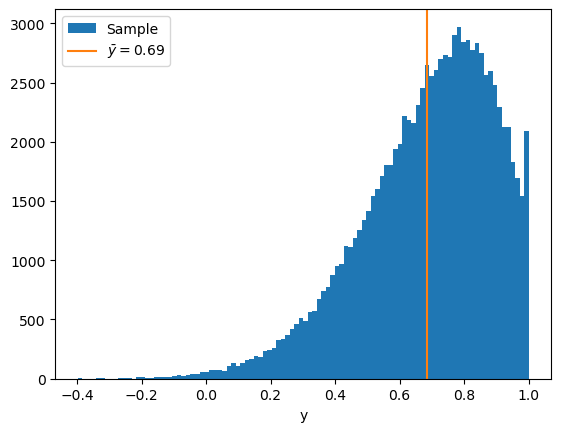

In [14]:
x = rng.normal(0.8, 0.3, size=100_000)
y = np.sin(x)
plt.hist(y, bins=100, label="Sample")
plt.axvline(np.mean(y), c="C1", label=f"$\\bar y = {np.mean(y):.2f}$")
plt.legend()
plt.xlabel("y");